In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
# import dataloader

I'm using a Lidar sensor to monitor a lane in 100m. I placed a series of reference marks on the lane in 0.5 intervals. If a vehicle presents on the lane, it will trigger the corresponding reference mark. In the data structure, you can image a binary array with 200 length indicating where the vehicle is. The LiDAR sample the data at 0.1sec, by concatenating the binary arrays across the time, we can yield a time space diagram with size of (200, t). For 1800 sec (half-hour) data collection, we can collect a mask with (200,18000) size. 

We are now designing a LSTM model predict the lane binary indicator in next frame according to historical frames: 
1) input: (batch, 200, historical_time_length), binary, 1 represents vehicle presence
2) output: (batch,200,1), binary, 1 represents vehicle presence

One challenge in this problem, is the occlusion. At certain frames, the lasers would be blocked by some vehicles in other lanes. So if we observe the time-space diagram, we may see some block-outs, and discontinuities in the trajectories at certain time frames or spaces. To this end, we need to create a model that can be aware of the occlusions, and during the loss function calculation. 

Please give me a Dataset class to read our data. Here is data description:

1) in this folder: D:\TimeSpaceDiagramDataset\space_time_diagram, we have our raw time-space diagrams in .npy format. (200,18000) each. Each file in this folder contains the full simulation of time-space trajectories across 1800 sec without occlusion problem. We will use them as the ground truth label.  

2) in this folder: D:\TimeSpaceDiagramDataset\space_time_diagram_aug, we have our post-occluded time-space diagram in .npy format in same size each, some cells are blocked out to simlulate the effect of occlusion.

3) in this folder: D:\TimeSpaceDiagramDataset\space_time_diagram_occlusion, the files are the occlusion mask in same size as previously described files. These files depict when and where the occlusion happened. 1 represents occlusion happpened, 0 represents no occlusion.

In each time we call the dataset class, we should output:

1) target (label): (batch_size, 200, 1) - indicator at time t. 

2) post_occlusion_mask (input): (batch_size, 200, past_time) - historical indicator from t - past_time to t -1 

3) occlusion_mask:  (batch_size, 200, past_time) - historical occlusion mask from t - past_time to t -1 




In [31]:

class OcclusionAwareTrafficDataset(Dataset):
    def __init__(self, data_dir, historical_length, future_length):
        self.data_dir = data_dir
        self.historical_length = historical_length
        self.future_length = future_length

        # Determine which folder to use based on whether it's training or validation
        self.folder_path = data_dir

        # Get list of file names (assuming they're numbered consistently across subfolders)
        self.file_names = [f for f in os.listdir(os.path.join(self.folder_path, 'target')) if f.endswith('.npy')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]

        # Load target (shape: 200, future_length)
        target_path = os.path.join(self.folder_path, 'target', file_name)
        target = np.load(target_path)
        target = target[:,:self.future_length]

        # Load post-occlusion label (shape: 200, historical_length)
        post_occ_path = os.path.join(self.folder_path, 'post_occ_label', file_name)
        post_occ_label = np.load(post_occ_path)
        post_occ_label = post_occ_label[:,-self.historical_length:]

        # Load occlusion mask label (shape: 200, historical_length)
        # occ_mask_path = os.path.join(self.folder_path, 'occ_mask_label', file_name)
        # occ_mask_label = np.load(occ_mask_path)

        # Convert to PyTorch tensors
        target_tensor = torch.FloatTensor(target)
        post_occ_tensor = torch.FloatTensor(post_occ_label)
        # occ_mask_tensor = torch.FloatTensor(occ_mask_label)


        return {
            'post_occ_X': post_occ_tensor,
            # 'occ_mask_X': occ_mask_tensor,
            'target': target_tensor
        }

In [32]:
# Custom loss function with distance-based weighting
class DistanceWeightedBCELoss(nn.Module):
    def __init__(self, max_distance=100):
        super(DistanceWeightedBCELoss, self).__init__()
        self.bce = nn.BCELoss(reduction='none')
        self.register_buffer('distance_weights', torch.linspace(1, 2, max_distance).unsqueeze(0).unsqueeze(-1))
    
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        weighted_loss = bce_loss * self.distance_weights
        return weighted_loss.mean()

In [33]:
class AttentionModule(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionModule, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_size)
        # encoder_outputs: (batch_size, seq_len, hidden_size)
        
        seq_len = encoder_outputs.size(1)
        
        # Repeat hidden state seq_len times
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Calculate attention scores
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        
        # Apply softmax to get attention weights
        return F.softmax(attention, dim=1)

class LSTMLanePredictorWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMLanePredictorWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = AttentionModule(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, num_lane_unit, historical_time_length)
        
        # Reshape input to (batch_size, historical_time_length, num_lane_unit)
        x = x.permute(0, 2, 1)
        
        # Forward propagate LSTM
        encoder_outputs, (hidden, _) = self.lstm(x)
        
        # Use the last hidden state to compute attention
        last_hidden = hidden[-1]
        
        # Compute attention weights
        attn_weights = self.attention(last_hidden, encoder_outputs)
        
        # Apply attention weights to encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        
        # Decode the context
        out = self.fc(context)
        
        # Reshape output to (batch_size, num_lane_unit, future_time_length)
        out = out.view(x.size(0), 200, -1)
        
        # Apply sigmoid to get probabilities
        out = self.sigmoid(out)
        
        return out, attn_weights


In [34]:
future_length = 1
historical_length = 10
train_dataset = OcclusionAwareTrafficDataset(data_dir=r"D:\TimeSpaceDiagramDataset\train", historical_length=historical_length , future_length=future_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = OcclusionAwareTrafficDataset(data_dir=r"D:\TimeSpaceDiagramDataset\val", historical_length=historical_length , future_length=future_length)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4)

In [35]:
# Hyperparameters
input_size = 200  # num_lane_unit
hidden_size = 128
num_layers = 2
output_size = 200 * future_length  # num_lane_unit * future_time_length (200 * 5)
learning_rate = 0.001
criterion = nn.BCELoss()
model = LSTMLanePredictorWithAttention(input_size, hidden_size, num_layers, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model_dir = r'D:\TimeSpaceDiagramDataset\models'


In [36]:
for batch in train_loader:
    targets = batch['target']  
    post_occlusion = batch['post_occ_X']
    break

In [37]:
continuity_degree = 0.2 # consider how much time of the model should consider for the continuity consideration
last_input_num = int(future_length * continuity_degree)
predictions, attn_weights = model(post_occlusion)
input_series = post_occlusion
batch_size, num_lanes, future_len = predictions.size()
_, _, his_len = input_series.size()

In [38]:
# Continuity loss
last_input  = input_series[:, :, -last_input_num:].unsqueeze(2)
first_pred = predictions[:, :, : last_input_num].unsqueeze(2)    # (batch, 200, 1)

continuity_loss = F.mse_loss(first_pred, last_input)

# Activity Level Consistency Loss
input_activity = input_series.mean(dim=2)   # (batch, 200)
pred_activity = predictions.mean(dim=2)     # (batch, 200)
activity_loss = F.mse_loss(pred_activity, input_activity)


C:\Users\zhChe\AppData\Local\Temp\ipykernel_22180\2343207464.py:5: UserWarning: Using a target size (torch.Size([32, 200, 1, 10])) that is different to the input size (torch.Size([32, 200, 1, 0])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  continuity_loss = F.mse_loss(first_pred, last_input)


RuntimeError: The size of tensor a (0) must match the size of tensor b (10) at non-singleton dimension 3

In [24]:
# weights = torch.linspace(1, 2, 200).unsqueeze(0).unsqueeze(-1)
criterion = nn.BCELoss()


In [25]:
val_loss = criterion(predictions, targets)

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
input_size = 200  # num_lane_unit
hidden_size = 128
num_layers = 2
validation_loss = {}
for historical_length in [5,10,20,30,40,50,70, 80 , 90, 100]:
    for future_length in [1,2,5,10,20,30,35,40,45,50]:
        print(historical_length,future_length)
        output_size = 200 * future_length  # num_lane_unit * future_time_length (200 * 5)
        best_model = LSTMLanePredictorWithAttention(input_size, hidden_size, num_layers, output_size)
        best_model.load_state_dict(torch.load(os.path.join(model_dir, f'lstm_{historical_length}_{future_length}.pth'),weights_only=False))
        best_model.eval()
        best_model.to(device)
        val_dataset = OcclusionAwareTrafficDataset(data_dir=r"D:\TimeSpaceDiagramDataset\val", historical_length=historical_length , future_length=future_length)
        val_loader = DataLoader(val_dataset, batch_size=32)
        val_loss = 0
        for batch in val_loader:
            targets = batch['target']  
            post_occlusion = batch['post_occ_X']
            targets = targets.to(device)
            post_occlusion = post_occlusion.to(device)
            predictions, attn_weights = best_model(post_occlusion)
            val_loss += criterion(predictions, targets)
        validation_loss[(historical_length, future_length)] = val_loss/len(val_loader)

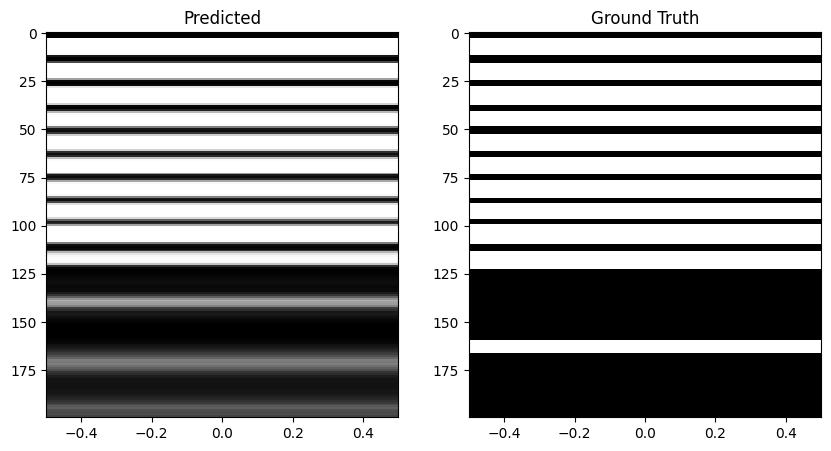

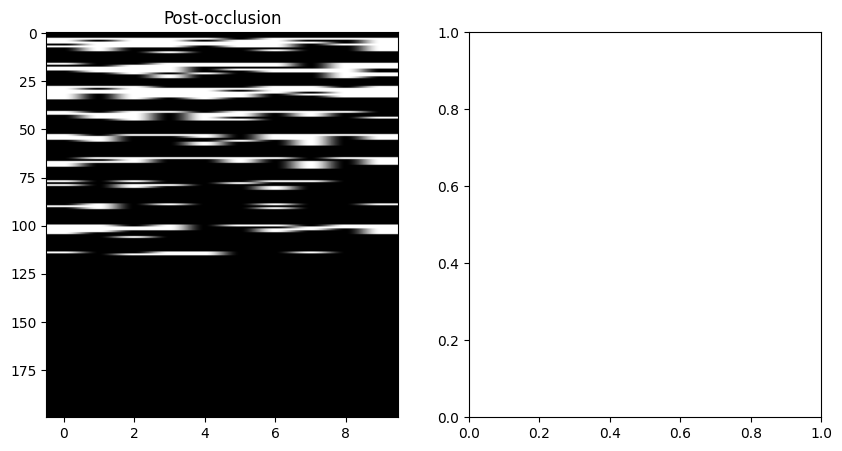

In [129]:
dict_data = val_dataset[1546]
post_occ_X = dict_data['post_occ_X']
# occ_mask_X = dict_data['occ_mask_X']
target = dict_data['target']
pred_occupation_status, attention_weights = best_model(post_occ_X.unsqueeze(0))
pred_occupation_status = pred_occupation_status[0].detach().numpy() 
label_occ_status = target.detach().numpy()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_occupation_status, cmap='gray', aspect='auto', interpolation='None')
plt.title('Predicted')
plt.subplot(1, 2, 2)
plt.imshow(label_occ_status, cmap='gray', aspect='auto', interpolation='None')
plt.title('Ground Truth')
plt.show()
# plot the input data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(post_occ_X.detach().numpy(), cmap='gray', aspect='auto')
plt.title('Post-occlusion')
plt.subplot(1, 2, 2)
# plt.imshow(occ_mask_X.detach().numpy(), cmap='gray', aspect='auto')
# plt.title('Occlusion Mask')
plt.show()

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

In [144]:
historical_length = 100
future_length = 5
output_size = 200 * future_length  # num_lane_unit * future_time_length (200 * 5)
best_model = LSTMLanePredictorWithAttention(input_size, hidden_size, num_layers, output_size)
best_model.load_state_dict(torch.load(os.path.join(model_dir, f'lstm_{historical_length}_{future_length}.pth'),weights_only=False))
best_model.eval()
best_model.to(device)

LSTMLanePredictorWithAttention(
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True)
  (attention): AttentionModule(
    (attn): Linear(in_features=256, out_features=128, bias=True)
    (v): Linear(in_features=128, out_features=1, bias=False)
  )
  (fc): Linear(in_features=128, out_features=1000, bias=True)
  (sigmoid): Sigmoid()
)

In [145]:
# read D:\TimeSpaceDiagramDataset\models\validation_loss.json
import json
with open(r'D:\TimeSpaceDiagramDataset\models\validation_loss.json') as f:
    validation_loss = json.load(f)

In [146]:
test_diagram = np.load(r"D:\TimeSpaceDiagramDataset\test.npy")
# make it upside down
test_diagram = np.flipud(test_diagram)
# pad zeros to make it 200 x-1

padding = np.zeros((200 - test_diagram.shape[0], test_diagram.shape[1]))
test_diagram = np.concatenate((test_diagram,padding), axis=0)

In [164]:


whole_pred_diagram = np.zeros(test_diagram.shape)

for frame_ind in tqdm(range(historical_length,test_diagram.shape[1] - future_length)):
    post_occ_X = torch.FloatTensor(test_diagram[:, frame_ind - historical_length:frame_ind]).to(device)
    target = torch.FloatTensor(test_diagram[:, frame_ind:frame_ind + future_length])
    pred_occupation_status, _ = best_model(post_occ_X.unsqueeze(0))
    pred_occupation_status = pred_occupation_status[0].cpu().detach().numpy()
    whole_pred_diagram[:, frame_ind:frame_ind + future_length] += pred_occupation_status

100%|██████████| 17884/17884 [00:14<00:00, 1259.07it/s]


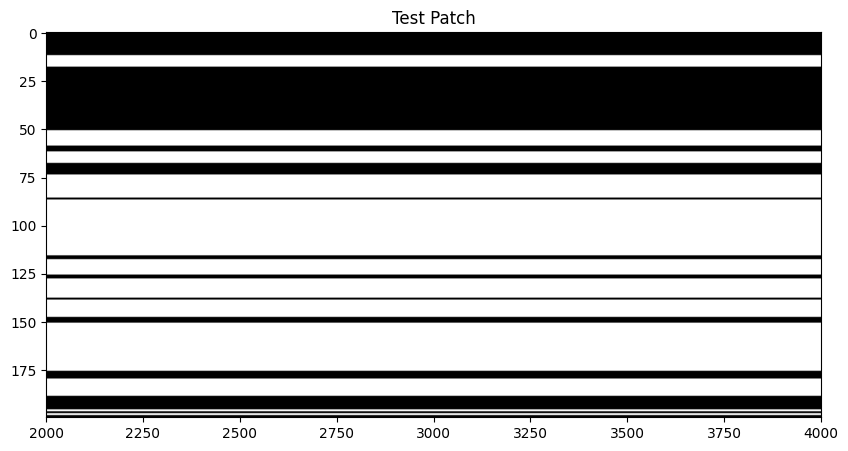

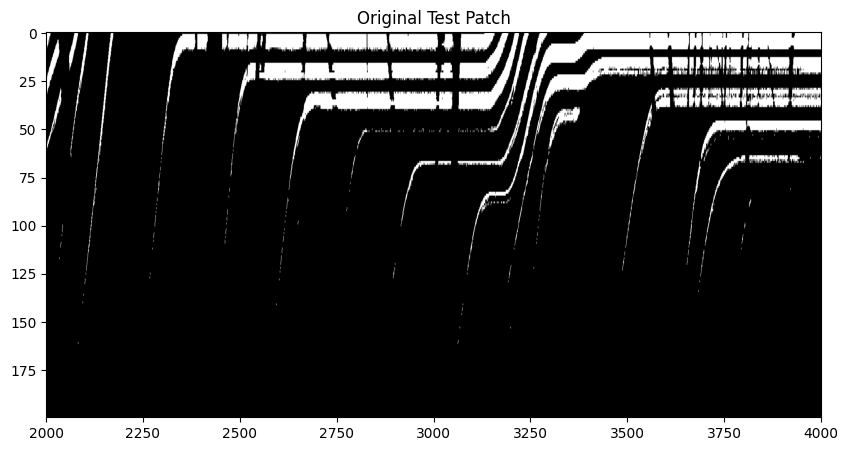

In [163]:
# plot test_patch
plt.figure(figsize=(10, 5))
plt.imshow(whole_pred_diagram > 4, cmap='gray', aspect='auto')
plt.title('Test Patch')
plt.xlim(2000, 4000)
plt.show()
# original test patch
plt.figure(figsize=(10, 5))
plt.imshow(test_diagram, cmap='gray', aspect='auto')
plt.title('Original Test Patch')
plt.xlim(2000, 4000)
plt.show()

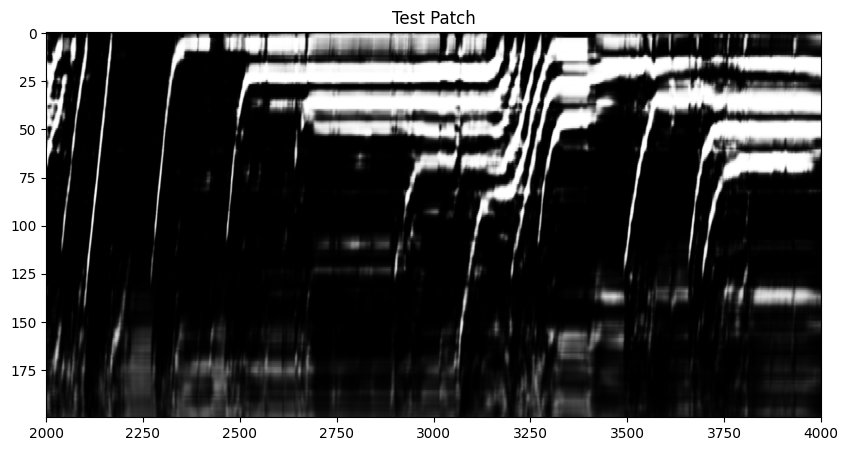

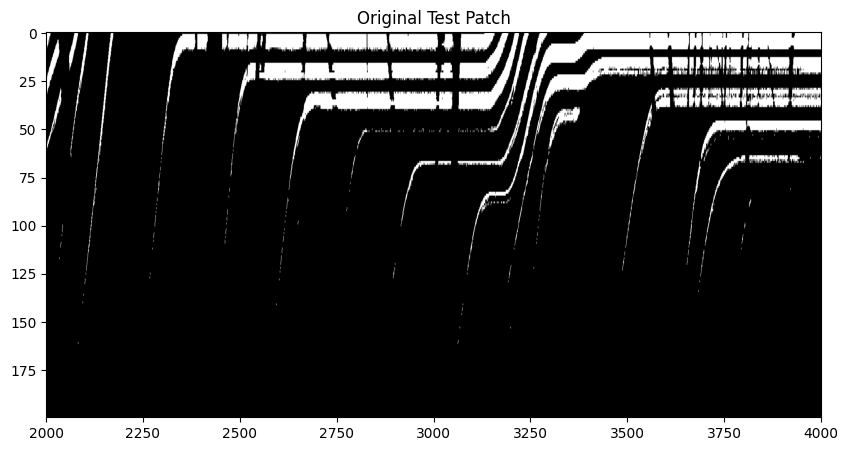

In [165]:
# plot test_patch
plt.figure(figsize=(10, 5))
plt.imshow(whole_pred_diagram, cmap='gray', aspect='auto')
plt.title('Test Patch')
plt.xlim(2000, 4000)
plt.show()
# original test patch
plt.figure(figsize=(10, 5))
plt.imshow(test_diagram, cmap='gray', aspect='auto')
plt.title('Original Test Patch')
plt.xlim(2000, 4000)
plt.show()

In [71]:
test_frame = 0
test_patch = test_diagram[:,test_frame:test_frame+historical_length].copy()
ground_truth = test_diagram[:,test_frame + historical_length: test_frame + historical_length + future_length].copy()
# convert to tensor and add batch dimension
test_patch = torch.tensor(test_patch).unsqueeze(0)
ground_truth = torch.tensor(ground_truth).unsqueeze(0)
# convert to float.32
test_patch = test_patch.float()
ground_truth = ground_truth.float()
pred_s_t, _ = best_model(test_patch)
pred_s_t = pred_s_t[0].detach().numpy().flatten()
mea_s_t = ground_truth.detach().numpy()[0].flatten()

In [112]:
filtered_diagram = np.zeros_like(test_diagram)
filtered_diagram[:,: historical_length] = test_diagram[:,: historical_length].copy()

# initialize the state and covariance
lane_units = 200
measurement_noise = np.ones(lane_units) * 0.1  # Adjust based on your sensor characteristics
model_uncertainty = np.ones(lane_units) * 0.1  # Adjust based on LSTM model performance

cur_covariance = np.eye(lane_units)
cur_state = filtered_diagram[:,historical_length].copy().flatten()

for frame_ind in tqdm(range(historical_length,filtered_diagram.shape[1] - future_length)):
    historical_s = filtered_diagram[:, frame_ind - historical_length:frame_ind].copy()
    # convert to tensor and add batch dimension
    historical_s = torch.tensor(historical_s).unsqueeze(0)
    # convert to float.32
    historical_s = historical_s.float()
    pred_s, _ = best_model(historical_s)
    pred_s = pred_s[0].detach().numpy().flatten()
    
    mea_s = filtered_diagram[:, frame_ind:frame_ind + future_length].copy().flatten()

    # update the state and covariance
    predicted_covariance = cur_covariance + np.diag(model_uncertainty)

    kalman_gain =  predicted_covariance.dot(np.linalg.inv(predicted_covariance + np.diag(measurement_noise)))

    cur_state = pred_s + kalman_gain.dot(mea_s - pred_s)
    cur_covariance = (np.eye(lane_units) - kalman_gain).dot(predicted_covariance)

    filtered_diagram[:,frame_ind:frame_ind + future_length] = cur_state.reshape(-1,1)

100%|██████████| 17978/17978 [05:03<00:00, 59.21it/s]


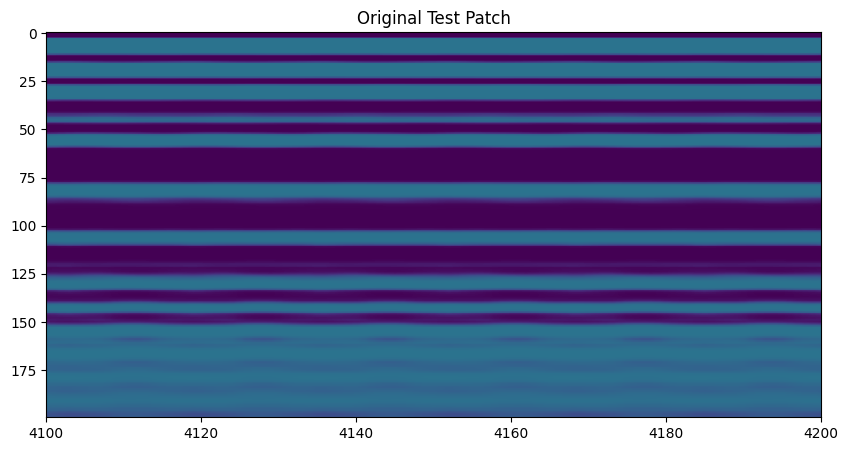

In [128]:
plt.figure(figsize=(10, 5))
plt.imshow(filtered_diagram, aspect='auto')
plt.title('Original Test Patch')
plt.xlim(4100, 4200)
plt.show()

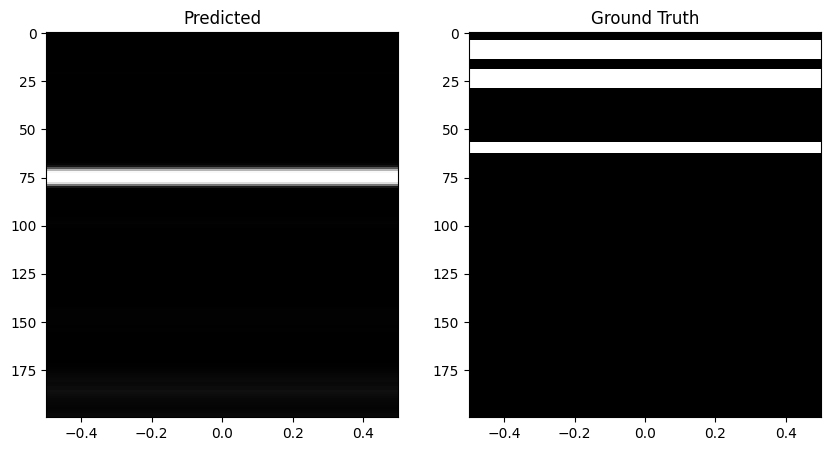

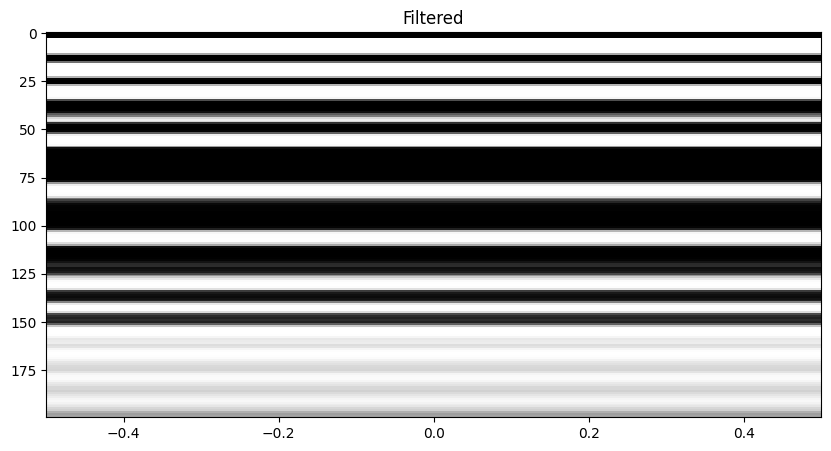

In [130]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_s_t.reshape(-1,1) , cmap='gray', aspect='auto', interpolation='None')
plt.title('Predicted')
plt.subplot(1, 2, 2)
plt.imshow(mea_s_t.reshape(-1,1), cmap='gray', aspect='auto', interpolation='None')
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(cur_state.reshape(-1,1), cmap='gray', aspect='auto', interpolation='None')
plt.title('Filtered')
plt.show()

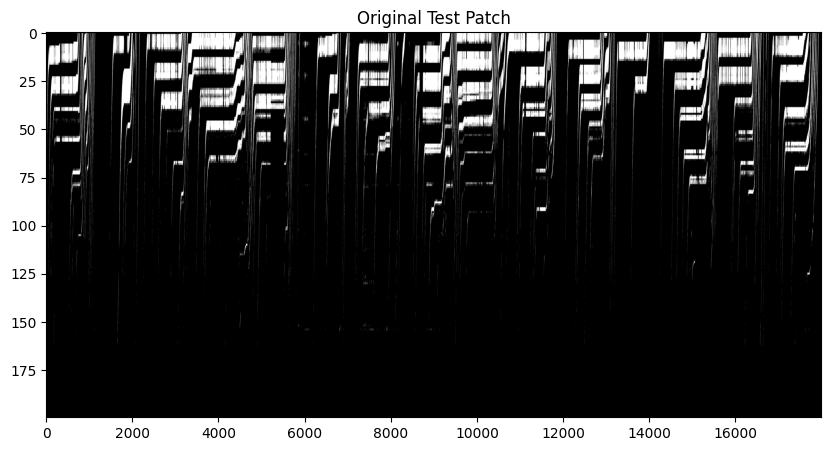

In [286]:
plt.figure(figsize=(10, 5))
plt.imshow(test_diagram, cmap='gray', aspect='auto')
plt.title('Original Test Patch')
# plt.xlim(4100, 4200)
plt.show()